In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
import pandas as pd


mpl.rcParams['figure.dpi'] = 100

In [2]:
import os
import sys 

# Jupyter Notebooks are not good at handling relative imports.
# Best solution (not great practice) is to add the project's path
# to the module loading paths of sys.

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
from utils.loaders import loadCorpusList, saveCorpus

corpusPath = '../data/corpus'

corpusList = loadCorpusList(corpusPath)
corpusList = [a for a in corpusList if a.lang == "es" and a.bagOfWords]
corpusList = [doc for doc in corpusList if doc.type == 'ARTÍCULOS']

len(corpusList)

706

In [4]:
n_topics = 70
MODELPATH = f'models/{n_topics}_topics/LDA_gensim_{n_topics}.model'

print(MODELPATH)

models/70_topics/LDA_gensim_70.model


In [5]:
from utils.exploration import get_articles_in_topic, get_titles_in_topic
from utils.exploration import get_keywords_in_topic, summary
from utils.exploration import summarize_topic, topic_top_n

Creating ../data/articles_in_topics.json


In [6]:
from gensim.models.ldamodel import LdaModel

lda = LdaModel.load(MODELPATH)
#lda = LdaModel.load("LDA_gensim_90_final.model")

In [7]:
!rm topics_{n_topics}.md

with open(f'topics_{n_topics}.md', 'a') as fp:
    for t in range(n_topics):
       
        num_articles = len(get_articles_in_topic(t, min_prob=0.5))
        
        if num_articles < 5:
            continue
            
        fp.write(f'\n# Topic {t}\n\n')
        fp.write(f'## Articles in topic: {num_articles}\n')
        
        
        fp.write('## Topic word probabilities:\n')
        fp.write('| Word | Probability |\n')
        fp.write('|---|---|\n')

        for word in topic_top_n(lda, t, n=20):

            fp.write(f"| {word[0]} | {word[1]} | \n")
            
        
        fp.write('\n## Top articles:\n')
            
        articles = get_articles_in_topic(t, min_prob=0.5, n=5)
        
        for article, _ in articles:
            try:
                year = datetime.datetime.strptime(article.date, "%Y/%m/%d").year
            except:
                year = article.date
                
            fp.write(f"* {article.author} ({year}). {article.title} [{article.id}]\n")

        fp.write('\n\\newpage')
        
!pandoc "topics_{n_topics}.md" -o topics_{n_topics}.pdf --pdf-engine=xelatex

---

In [8]:
years = []
for topic in range(90):
    years +=[{'topic': topic, 'year': article[0].year, 'id':article[0].id} for article in get_articles_in_topic(topic, min_prob=0.5)]

In [9]:
df = pd.DataFrame(years)

In [10]:
df['year'] = df['year'].astype(int)
df['year'] = pd.cut(df['year'], bins = [x for x in range(1950, 2021, 5)])


In [11]:
yearProgression = df.groupby(['year', 'topic']).count().unstack()
yearProgression.fillna(0, inplace = True)

In [12]:
yearProgression.columns = [index[1] for index in yearProgression.columns]

In [13]:
yearProgression = yearProgression[yearProgression.columns[yearProgression.sum()>=10]]

In [14]:
#per = yearProgression.apply(lambda x: x / x.sum() * 100, axis = 1).fillna(0)
per = yearProgression

per['end'] = [x.right for x in per.index]

per.set_index('end', inplace = True)

per = per[per.index > 1970]

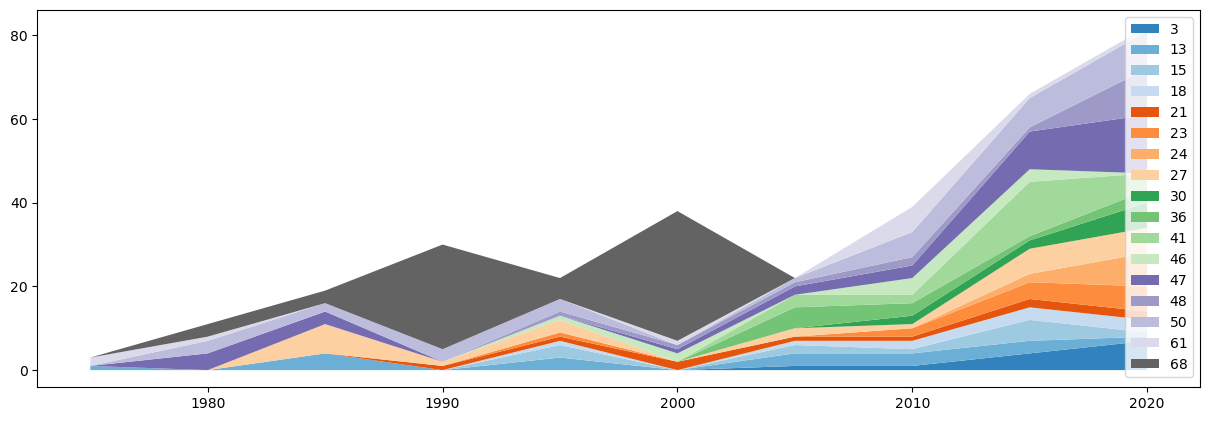

In [15]:
fig = plt.figure(figsize=(15,5))

from cycler import cycler 

colors = plt.cm.tab20c.colors

plt.gca().set_prop_cycle(cycler('color', colors))

base = 0
c = 0.01
for topic in per.iteritems():
    data = topic[1]
    
    plt.fill_between(per.index, y1 = base, y2 = base + data, label = topic[0])
    
    base += data
    c += 0.08
    
plt.legend()

---

In [16]:
with open('../data/gridsearch.json') as fp:
    grid = pd.read_json(fp.read())

In [17]:
grid[50][0]

{'coherence': 0.39804996997866304,
 'log_perplexity': -10.212300407225916,
 'time_lda': 176.48310446739197,
 'time_coherence': 72.52659440040588,
 'n_articles_per_topic': {'0': 217,
  '9': 23,
  '44': 1,
  '4': 27,
  '7': 46,
  '17': 43,
  '27': 4,
  '11': 53,
  '29': 11,
  '2': 183,
  '21': 14,
  '10': 18,
  '6': 12,
  '26': 39,
  '36': 16,
  '1': 15,
  '20': 20,
  '39': 5,
  '3': 2,
  '15': 3,
  '33': 9,
  '14': 13,
  '18': 1,
  '46': 2,
  '35': 3,
  '23': 3,
  '5': 4,
  '48': 1,
  '19': 4,
  '8': 3,
  '12': 4,
  '38': 4,
  '43': 2,
  '24': 2,
  '49': 1,
  '32': 4,
  '13': 2,
  '16': 3,
  '28': 1,
  '22': 1,
  '45': 1,
  '42': 1,
  '30': 1}}

In [18]:
from collections import defaultdict

data = []
for n_topics in grid:
    for iteration in grid[n_topics]:
        grid_df = defaultdict()

        grid_df['num_topics'] = n_topics
        
        grid_df['coherence'] = iteration['coherence']

        for key, value in iteration['n_articles_per_topic'].items():
            if key == '-1':
                grid_df['orphans'] = value
                
        n_docs_topic = [x for k, x in iteration['n_articles_per_topic'].items() if k != '-1']
        
        grid_df['num_classified_docs'] = sum(n_docs_topic)
        
        grid_df['avg_num_docs'] = np.mean(n_docs_topic)
        grid_df['std_num_docs'] = np.std(n_docs_topic)

        grid_df['max_docs_topic'] = np.max(n_docs_topic)
        grid_df['min_docs_topic'] = np.min(n_docs_topic)

        grid_df['useful_topics'] = len([x for x in n_docs_topic if x >= 5])
        
        #grid_df['classified_docs'] = sum(n_docs_topic)
        
        data.append(grid_df)
        
grid_df = pd.DataFrame(data)

In [19]:
grid_df

,num_topics,coherence,num_classified_docs,avg_num_docs,std_num_docs,max_docs_topic,min_docs_topic,useful_topics,orphans
0,50,0.398050,822,19.116279,42.186854,217,1,18,NaN
1,50,0.364074,822,21.076923,45.959505,268,1,17,NaN
2,50,0.362270,822,19.571429,45.515117,248,1,22,NaN
3,60,0.390986,822,19.571429,41.175087,195,1,17,NaN
4,60,0.399338,822,17.489362,47.369921,286,1,14,NaN
5,60,0.405124,822,16.775510,42.585456,252,1,23,NaN
6,70,0.361062,822,16.775510,30.408287,147,1,20,NaN
7,70,0.377396,822,17.125000,52.599756,348,1,16,NaN
8,70,0.379486,822,18.681818,59.604672,353,1,11,NaN
9,80,0.397034,822,16.440000,41.219005,231,1,23,NaN


Text(0.5, 0, 'Num. of topics in model')

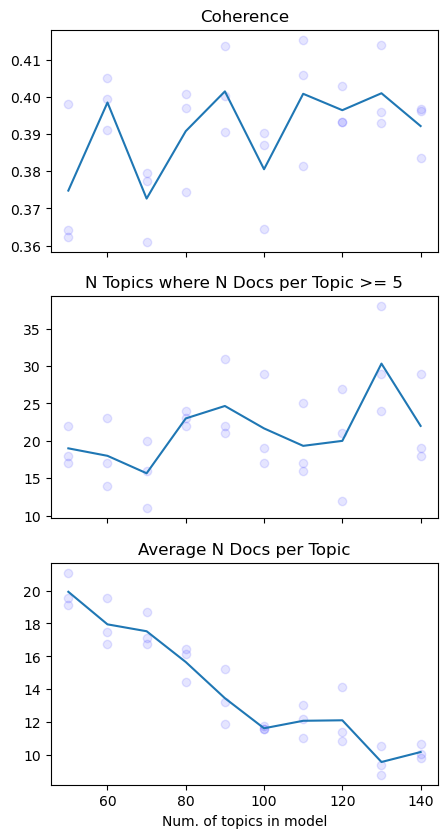

In [27]:
fig, axes = plt.subplots(3, 1, sharex = True, figsize = (5, 10))

data = grid_df.groupby('num_topics')

plot_counter = 0

labels = {'coherence': 'Coherence',
         'useful_topics': 'N Topics where N Docs per Topic >= 5',
         'avg_num_docs': 'Average N Docs per Topic'}

for metric in ['coherence', 'useful_topics', 'avg_num_docs']:
       
    mins = data[metric].min()
    maxs = data[metric].max()
    avgs = data[metric].mean()

    axes[plot_counter].plot(avgs.index, avgs)
    #axes[plot_counter].fill_between(mins.index, mins, maxs, alpha = 0.1)
    axes[plot_counter].set_title(labels[metric])
    
    axes[plot_counter].scatter(grid_df['num_topics'], grid_df[metric], color = 'Blue', alpha = 0.1)

    plot_counter += 1

plt.xlabel('Num. of topics in model')

In [ ]:
axes

---

In [ ]:
yearsCount = [int(x.year) for x in corpusList]

ax = sns.histplot(yearsCount, bins=50)

In [ ]:
wordCounts = pd.Series([len(x.bagOfWords.split()) for x in corpusList if len(x.bagOfWords) > 0])
print(wordCounts.describe())

words = []
for doc in corpusList:
    words += list(set(doc.bagOfWords.split()))

print(f"Total number of words: {len(words)}")

In [ ]:
from collections import defaultdict
data = []
for doc in corpusList:
    
    if int(doc.year) < 1985:
        continue
        
    row = defaultdict()
    row['id'] = doc.id
    row['year'] = doc.year
    row['length'] = len(doc.bagOfWords.split())
    
    data.append(row)
    
words_df = pd.DataFrame(data)

In [ ]:
words_df = words_df.groupby('year').mean()

In [ ]:
plt.figure(figsize = (10, 5))
plt.plot(words_df.index, words_df['length'])
_ = plt.xticks(rotation = 90)

In [ ]:
[f"{x.title} [{x.id}]: {len(x.bagOfWords)}" for x in corpusList if x.year == '2007']